<div style="border: 2px solid #e74c3c; padding: 10px; border-radius: 5px; text-align: center; background-color: #fdecea; color: #c0392b; font-weight: bold;">
 Stochastic Gradient descent
</div>

Nous allons entraîner un modèle de régression pour prédire le poids d'une personne à partir de sa taille. Le modèle est une régression linéaire avec une variable explicative (le poids) et une constante. Le modèle est optimisé sous une perte des moindres carrés. La variable $b$ contient les cibles de prédiction (un vecteur de la longueur du jeu de données) et la variable $A$ est la matrice de données, contenant (1) une colonne de uns et (2) une colonne avec la variable explicative.

In [4]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
from helpers import load_data, standardize, build_model_data, batch_iter
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Les données

In [5]:
height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
b, A = build_model_data(x, weight)

In [25]:
print('(n, d) = ', A.shape)

(n, d) =  (10000, 2)


# Estimation des moindres carrés


L'estimation des moindres carrés est l'un des algorithmes fondamentaux de l'apprentissage automatique. Étant donné une matrice $ n \times d $ $A$ et un vecteur $ n \times 1 $ $b$, l'objectif est de trouver un vecteur $x \in \mathbb{R}^d$ qui minimise la fonction objectif :

$$f(x) = \frac{1}{2n} \sum_{i=1}^{n} (a_i^\top x - b_i)^2 = \frac{1}{2n} \|Ax - b\|^2 $$

Dans cet exercice, nous allons essayer d'ajuster $x$ en utilisant l'estimation des moindres carrés.

On peut voir que la fonction est $\mu$-fortement convexe avec $\mu = \lambda_{min}(\nabla^2 f(x)) = \frac{1}{n} \lambda_{min}(A^T A) $ et $L$-lisse avec $L = \lambda_{max}(\nabla^2 f(x)) = \frac{1}{n} \lambda_{max}(A^T A)$, car ici la matrice Hessienne est constante, indépendante de $x$.

Lorsque $A^{T} A$ est inversible, ce qui est le cas ici, nous avons alors une solution simple sous forme fermée pour (l'unique) $x^* = \text{argmin}_{x \in \mathbb{R}^d} f(x)$. En effet, résoudre $\nabla f(x^*) = 0$ conduit à 
$$x^* = (A^T A)^{-1} A^T b$$

 Cependant, lorsque $n$ et $d$ sont grands (ce qui est le cas dans les problèmes modernes de **big data**), utiliser cette formule peut-être complexe du point de vue **computationnel**, d'où la nécessité d'utiliser des algorithmes tels que la descente de gradient stochastique (SGD), qui considèrent un point de données après l'autre.

Dans ce TP, puisque $n$ et $d$ sont petits, et afin de montrer les taux de convergence vus en classe, nous commençons par calculer $f(x^*)

In [11]:
def full_objective(targets_b, data_A, params_x):
    """Compute the least squares objective over the whole dataset"""
    return 0.5 * np.mean(((data_A @ params_x) - targets_b)**2)

In [ ]:
# inverser une matrice
def inv(A):
    return np.linalg.inv(A)

In [17]:
x_star = np.linalg.inv(A.T@A) @ (A.T@b)
best_objective = full_objective(b, A, x_star)
print("x_optimal = ", x_star)
print("f(x*) = ", best_objective)

x_optimal =  [73.293922   13.47971243]
f(x*) =  15.3858878688294


# Stochastic Gradient Descent

In [18]:
def minibatch_gradient(targets_b, data_A, params_x):
    """
    Compute a mini-batch stochastic gradient from a subset of `num_examples` from the dataset.
    
    :param targets_b: a numpy array of shape (num_examples)
    :param data_A: a numpy array of shape (num_examples, num_features)
    :param params_x: compute the mini-batch gradient at these parameters, numpy array of shape (num_features)
    
    :return: gradient: numpy array of shape (num_features)
    """
    batch_size = len(targets_b)
    err = targets_b - data_A.dot(params_x)
    grad = -data_A.T.dot(err) / batch_size
    return grad

In [19]:
def stochastic_gradient(targets_b, data_A, params_x, batch_size=1):
    """
    Compute a stochastic gradient
    
    :param targets_b: numpy array of size (num_examples)
    :param data_A: numpy array of size (num_examples, num_features)
    :param params_x: compute the mini-batch gradient at these parameters, numpy array of shape (num_features)
    :param batch_size: integer: number of datapoints to compute the stochastic gradient from
    
    :return: gradient, numpy array of shape (num_features)
    """
    dataset_size = len(targets_b)
    indices = np.random.choice(dataset_size, batch_size, replace=False)
    return minibatch_gradient(targets_b[indices], data_A[indices, :], params_x)

def stochastic_gradient_descent(
        targets_b, 
        data_A, 
        initial_x, 
        batch_size, 
        max_iters, 
        initial_learning_rate, 
        decreasing_learning_rate=False):
    """
    Mini-batch Stochastic Gradient Descent for Linear Least Squares problems.
    
    :param targets_b: numpy array of size (num_examples)
    :param data_A: numpy array of size (num_examples, num_features)
    :param initial_x: starting parameters, a numpy array of size (num_features)
    :param batch_size: size of the mini-batches
    :param max_iters: integer, number of updates to do
    :param initial_learning_rate: float
    :param decreasing_learning_rate: if set to true, the learning rate should decay as 1 / t 
    
    :return:
    - objectives, a list of loss values on the whole dataset, collected at the end of each pass over the dataset (epoch)
    - param_states, a list of parameter vectors, collected at the end of each pass over the dataset
    """
    xs = [initial_x]  # parameters after each update 
    objectives = []  # loss values after each update
    x = initial_x
    
    for iteration in range(max_iters):
        grad = stochastic_gradient(targets_b, data_A, x, batch_size=batch_size)
        if decreasing_learning_rate:
            lr = initial_learning_rate / (iteration + 1)
        else:
            lr = initial_learning_rate

        # update x through the stochastic gradient update
        x = x - lr * grad

        # store x and objective
        xs.append(x.copy())
        objective = full_objective(targets_b, data_A, x)
        objectives.append(objective)
        
        if iteration % 1000 == 0:
            print("SGD({bi:04d}/{ti:04d}): objective = {l:10.2f}".format(
                  bi=iteration, ti=max_iters - 1, l=objective))
    return objectives, xs

Testons ceci dans l'exemple ci dessous.

In [20]:
# Define the parameters of the algorithm.
max_iters = int(1e4)  # 10 passes through the dataset
gamma = 0.2   # this is totally arbitrary
batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives, sgd_xs = stochastic_gradient_descent(
    b, A, x_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: Temps d'execution={t:.3f} secondes".format(t=exection_time))

SGD(0000/9999): objective =    1515.44
SGD(1000/9999): objective =      15.63
SGD(2000/9999): objective =      16.78
SGD(3000/9999): objective =      18.20
SGD(4000/9999): objective =      19.44
SGD(5000/9999): objective =      18.70
SGD(6000/9999): objective =      17.48
SGD(7000/9999): objective =      23.95
SGD(8000/9999): objective =      21.21
SGD(9000/9999): objective =      19.90
SGD: Temps d'execution=2.277 secondes


Time Visualization

interactive(children=(IntSlider(value=1, description='n_iter', max=10001, min=1), Output()), _dom_classes=('wi…

<function __main__.plot_figure(n_iter)>

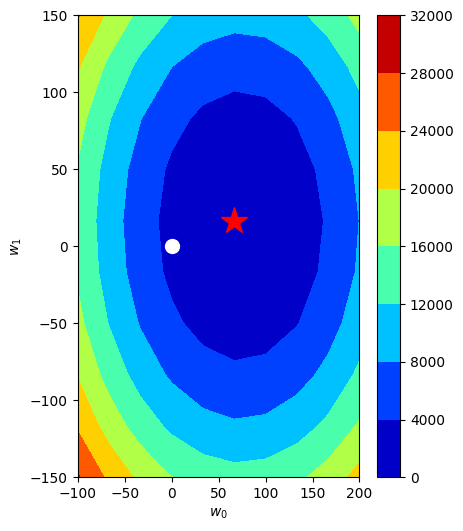

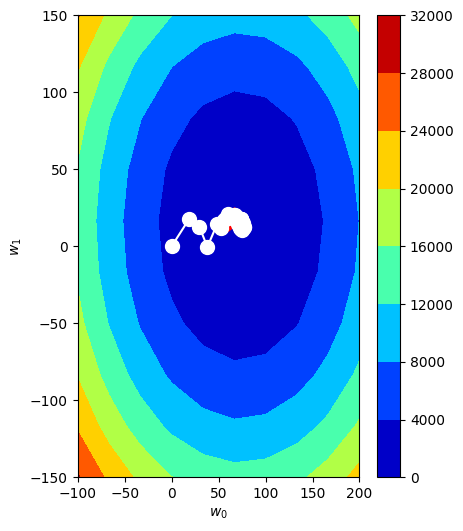

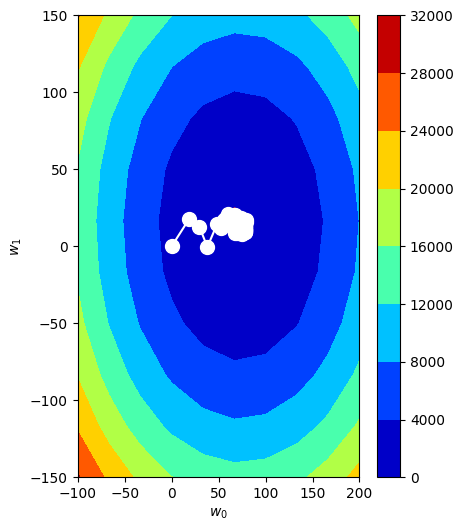

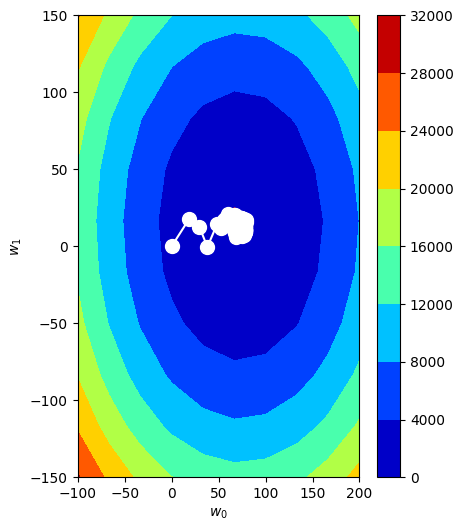

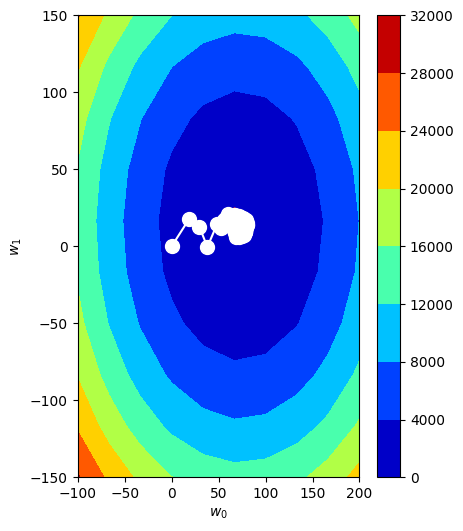

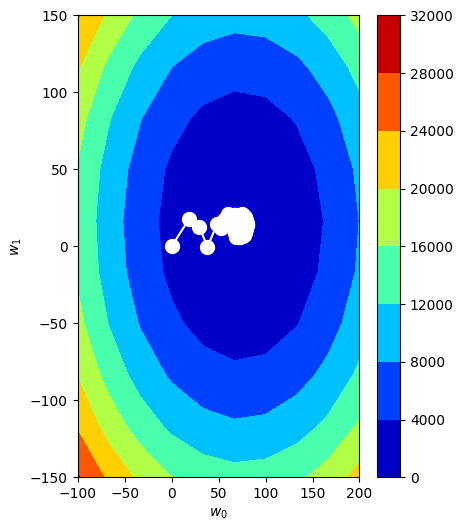

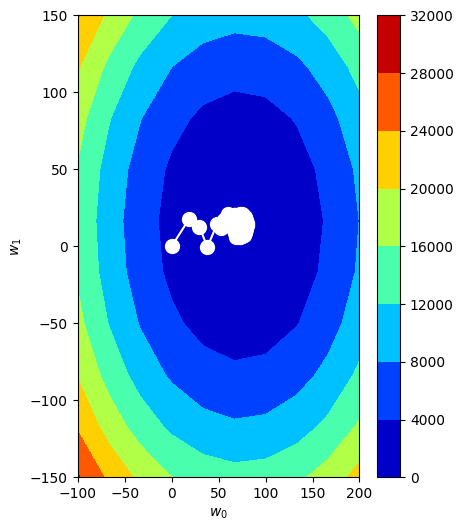

In [21]:
from plots import gradient_descent_visualization
from ipywidgets import IntSlider, interact
from grid_search import *


grid_x0, grid_x1 = generate_w(num_intervals=10)
grid_objectives = grid_search(b, A, grid_x0, grid_x1)
loss_star, x0_star, x1_star = get_best_parameters(grid_x0, grid_x1, grid_objectives)

def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_objectives, sgd_xs, grid_objectives, grid_x0, grid_x1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_xs)))

#### Plotting the convergence

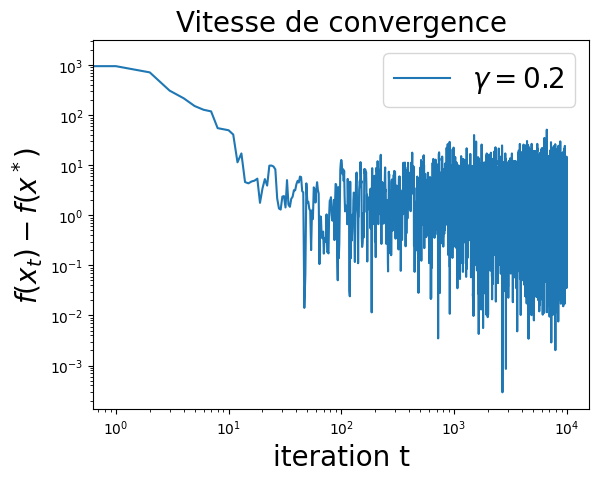

In [24]:
plt.title('Vitesse de convergence', fontsize = 20)
plt.loglog(sgd_objectives - best_objective, label = r'$\gamma = 0.2$')
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

Notez que l'utilisation d'une taille de pas constante arbitraire ne conduit pas à une convergence appropriée : les itérations "saturent" à cause du bruit stochastique et cessent de progresser à un certain point. Nous devons donc utiliser des tailles de pas plus appropriées.

# Learning Rate Optimal

## En supposant des gradients stochastiques attendus bornés

Supposons que nous nous déplaçons dans une région bornée $|x| \leq 25$ contenant toutes les itérations (et nous supposons $|x-x^\star| \leq 25$ également, pour simplifier). Par $\nabla f(x) = \frac{1}{n}A^\top (Ax - b)$, on peut voir que $f$ est Lipschitz sur cette région bornée, avec une constante de Lipschitz $|\nabla f(x)| \leq \frac{1}{n} (|A^\top A||x| + |A^\top Ab|)$. Nous savons également que $E\big[|g_t|\big | x_t\big] = \nabla f(x)$. Donc, pour trouver $B$ tel que $E\big[|g_t|^2\big] \leq B^2$, nous devons calculer la constante de Lipschitz.

In [26]:
grad_norm_bound = (25*np.linalg.norm(np.dot(A.T,A)) + np.linalg.norm(np.dot(A.T,b)))/A.shape[0]

# Define the parameters of the algorithm.
max_iters = int(1e4)

gamma = 25 / (grad_norm_bound * np.sqrt(max_iters)) # Fill in a better learning rate  

batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives_dec_gamma, sgd_xs_dec_gamma = stochastic_gradient_descent(
    b, A, x_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD(0000/9999): objective =    2774.61
SGD(1000/9999): objective =      44.50
SGD(2000/9999): objective =      15.40
SGD(3000/9999): objective =      15.43
SGD(4000/9999): objective =      15.43
SGD(5000/9999): objective =      15.41
SGD(6000/9999): objective =      15.41
SGD(7000/9999): objective =      15.48
SGD(8000/9999): objective =      15.47
SGD(9000/9999): objective =      15.42
SGD: execution time=2.810 seconds


Time visualization with a better learning rate

interactive(children=(IntSlider(value=1, description='n_iter', max=10001, min=1), Output()), _dom_classes=('wi…

<function __main__.plot_figure(n_iter)>

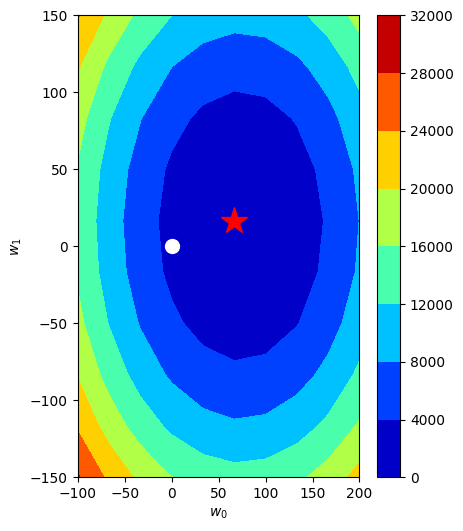

In [27]:
interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_xs_dec_gamma)))

#### Plotting the convergence

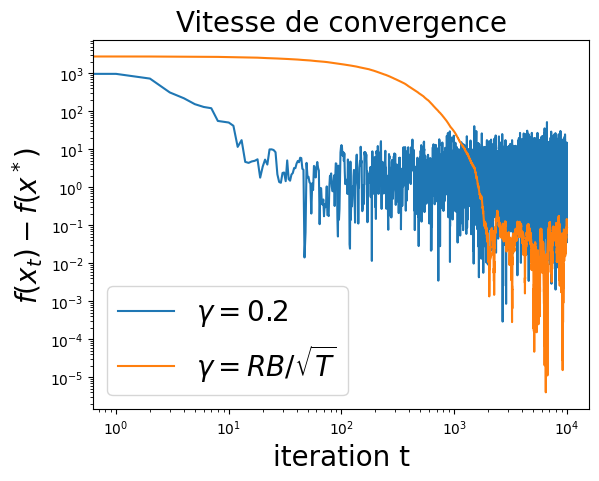

In [29]:
plt.title('Vitesse de convergence', fontsize = 20)
plt.loglog(sgd_objectives - best_objective, label = r'$\gamma = 0.2$')
plt.loglog(sgd_objectives_dec_gamma - best_objective, label = r'$\gamma = R B / \sqrt{T}$')
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

La convergence avec le taux optimal est plus stable.

## SGD  avec une convexité forte

Essayons de faire de la descente de gradient stochastique (SGD) avec un meilleur taux d'apprentissage en utilisant le fait que la fonction objectif est fortement convexe.
(Indice : vous pouvez utiliser un paramètre de pas décroissant gamma dans la descente de gradient stochastique.)

In [30]:
# Define the parameters of the algorithm.
max_iters = int(1e4)


mu = np.linalg.norm(A.T@A, -2) / len(A)   
L = np.linalg.norm(A.T@A, 2) / len(A)

gamma0 = 2 / mu
batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives_dec_gamma_mu, sgd_xs_dec_gamma_mu = stochastic_gradient_descent(
    b, A, x_initial, batch_size, max_iters, gamma0, decreasing_learning_rate=True)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD(0000/9999): objective =    5253.85
SGD(1000/9999): objective =      15.50
SGD(2000/9999): objective =      15.44
SGD(3000/9999): objective =      15.39
SGD(4000/9999): objective =      15.39
SGD(5000/9999): objective =      15.39
SGD(6000/9999): objective =      15.39
SGD(7000/9999): objective =      15.39
SGD(8000/9999): objective =      15.39
SGD(9000/9999): objective =      15.39
SGD: execution time=2.410 seconds


### Plotting the convergences

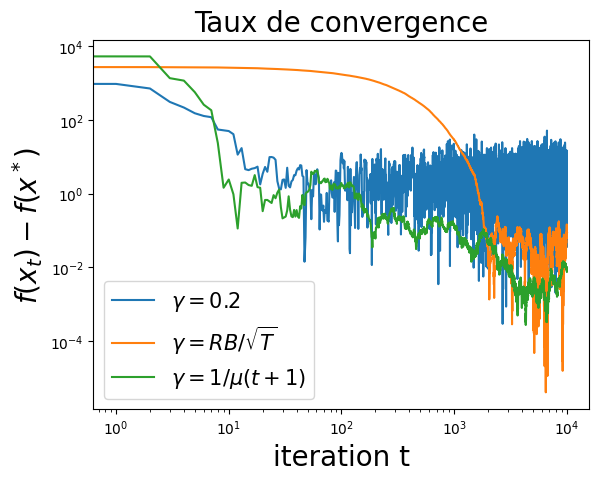

In [31]:
plt.title('Taux de convergence', fontsize = 20)
plt.loglog(sgd_objectives - best_objective, label = r'$\gamma = 0.2$')
plt.loglog(sgd_objectives_dec_gamma - best_objective, label = r'$\gamma = R B / \sqrt{T}$')
plt.loglog(sgd_objectives_dec_gamma_mu - best_objective, label = r'$\gamma = 1 / \mu (t + 1)$')
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)
plt.legend(fontsize = 15)
plt.show()

La  convergence est plus stable. La vitesse de convergence étant  $O(\frac{1}{t})$

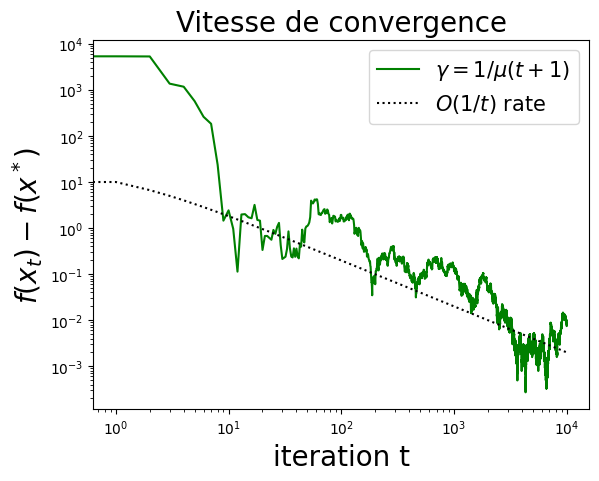

In [33]:
tab = np.arange(1, max_iters)

plt.title('Vitesse de convergence', fontsize = 20)
plt.loglog(sgd_objectives_dec_gamma_mu - best_objective, label = r'$\gamma = 1 / \mu (t + 1)$', color = 'g')
plt.loglog(20 / tab, label = r'$O(1 / t)$ rate', color = 'k', linestyle = 'dotted')
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)
plt.legend(fontsize = 15)
plt.show()

## Evolution de la fonction objective



Nous allons comparer le SGD et le GD.

In [34]:
from gradient_descent import gradient_descent
T = 5 # number of full gradient computed

x_initial = np.zeros(A.shape[1])
gradient_objectives, gradient_xs = gradient_descent(b, A, x_initial, T, 1/(2 *L))
# Define the parameters of the algorithm.

max_iters = T * A.shape[0] # number of stochastic gradients which can be computed during the same time T (for batch size 1)
sgd_objectives_dec_gamma_mu, sgd_xs_dec_gamma = stochastic_gradient_descent(
    b, A, x_initial, 1, max_iters, 2 / mu, decreasing_learning_rate=True)

Gradient Descent(0/4): objective=2792.2367127591674
Gradient Descent(1/4): objective=709.5985940914233
Gradient Descent(2/4): objective=188.93906442447854
Gradient Descent(3/4): objective=58.774182007742255
Gradient Descent(4/4): objective=26.232961403557642
SGD(0000/49999): objective =   52481.66
SGD(1000/49999): objective =      15.39
SGD(2000/49999): objective =      15.39
SGD(3000/49999): objective =      15.39
SGD(4000/49999): objective =      15.39
SGD(5000/49999): objective =      15.39
SGD(6000/49999): objective =      15.39
SGD(7000/49999): objective =      15.39
SGD(8000/49999): objective =      15.39
SGD(9000/49999): objective =      15.39
SGD(10000/49999): objective =      15.39
SGD(11000/49999): objective =      15.39
SGD(12000/49999): objective =      15.39
SGD(13000/49999): objective =      15.39
SGD(14000/49999): objective =      15.39
SGD(15000/49999): objective =      15.39
SGD(16000/49999): objective =      15.39
SGD(17000/49999): objective =      15.39
SGD(18000/499

Note that SGD takes a pretty long time to run because we ask it to compute the full objective at each iteration, this is not done in practice because it is computationally heavy.

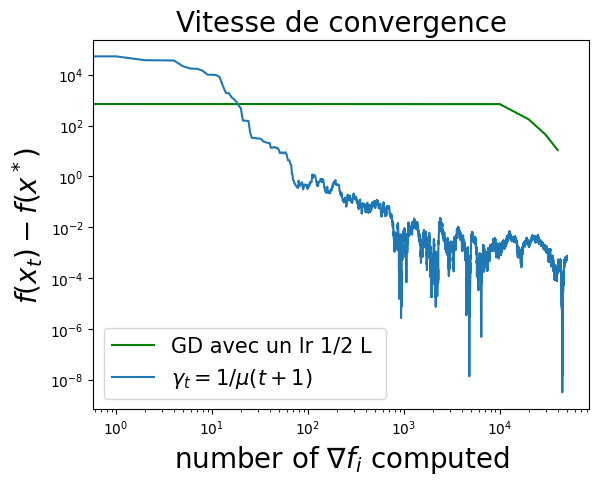

In [35]:
plt.title('Vitesse de convergence', fontsize = 20)
plt.loglog(range(0,len(gradient_objectives)*10000,10000),
         gradient_objectives - best_objective,'g', label='GD avec un lr 1/2 L ')
plt.loglog(sgd_objectives_dec_gamma_mu - best_objective, label = r'$\gamma_t = 1 / \mu (t + 1)$')
plt.xlabel(r'number of $\nabla f_i$ computed'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)
plt.legend(fontsize = 15)
plt.show()

Notez que la descente de gradient stochastique (SGD) est beaucoup plus rapide que la descente de gradient (GD) au début (GD deviendra finalement plus rapide) et est donc plus attrayante sur le plan computationnel.

# Nouveau jeu de données

In [36]:
data = np.loadtxt("Concrete_data.csv",delimiter=",")

A = data[:,:-1]
b = data[:,-1]
A, mean_A, std_A = standardize(A)

In [37]:
b.shape, A.shape

((1030,), (1030, 8))

In [41]:
x_star = np.linalg.inv(A.T@A) @ (A.T@b)
best_objective = full_objective(b, A, x_star)
print('x* = ', x_star)
print('f(x*) = ', best_objective)

x* =  [12.51423615  8.95712234  5.62480067 -3.19983624  1.74485575  1.40559189
  1.61799518  7.21189448]
f(x*) =  695.0617890478907


# Running stochastic gradient descent

Testez des LR différents pour vérifier les effets sur la vitesse de convergence.

###### Fixed step size

In [42]:
max_iters = int(1e4)

gamma = 0.01   # totally arbitrary  

batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives, sgd_xs = stochastic_gradient_descent(
    b, A, x_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD(0000/9999): objective =     786.09
SGD(1000/9999): objective =     716.49
SGD(2000/9999): objective =     704.32
SGD(3000/9999): objective =     741.09
SGD(4000/9999): objective =     706.40
SGD(5000/9999): objective =     722.41
SGD(6000/9999): objective =     740.86
SGD(7000/9999): objective =     718.50
SGD(8000/9999): objective =     727.92
SGD(9000/9999): objective =     721.23
SGD: execution time=0.250 seconds


###### Decreasing step size

In [43]:
# Define the parameters of the algorithm.
max_iters = int(1e4)

# You may use these results from last week
mu = np.linalg.norm(A.T@A, -2) / len(A)   
L = np.linalg.norm(A.T@A, 2) / len(A)

gamma0 = 0.01 / mu   # if you use 1 / mu it will explode 
batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives_dec_gamma_mu, sgd_xs_dec_gamma = stochastic_gradient_descent(
    b, A, x_initial, batch_size, max_iters, gamma0, decreasing_learning_rate=True)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD(0000/9999): objective =    2170.32
SGD(1000/9999): objective =     729.81
SGD(2000/9999): objective =     718.81
SGD(3000/9999): objective =     714.87
SGD(4000/9999): objective =     712.51
SGD(5000/9999): objective =     711.00
SGD(6000/9999): objective =     710.09
SGD(7000/9999): objective =     709.40
SGD(8000/9999): objective =     708.66
SGD(9000/9999): objective =     708.13
SGD: execution time=0.254 seconds


# Plotting the Evolution of the Objective Function

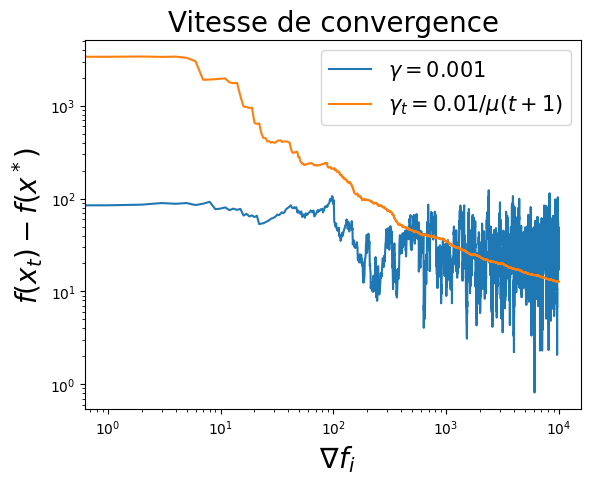

In [44]:
plt.title('Vitesse de convergence', fontsize = 20)
plt.loglog(sgd_objectives - best_objective, label = r'$\gamma = 0.001$')
plt.loglog(sgd_objectives_dec_gamma_mu - best_objective, label = r'$\gamma_t = 0.01 / \mu (t + 1)$')
plt.xlabel(r' $\nabla f_i$ '  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)
plt.legend(fontsize = 15)
plt.show()

# Projected Stochastic Gradient Descent

Pour éviter que $x$ ne devienne trop grand, nous pouvons effectuer une optimisation sous contrainte en projetant $x$ sur une boule $\text{L}_2$ à chaque itération, limitant ainsi la norme de $x$

In [45]:
l2_ball_radius = 100  
def projection(x):
    """project x onto an l2-ball"""
    norm = np.linalg.norm(x) 
    if norm > l2_ball_radius:
        x = x * (l2_ball_radius / norm)
    return x

In [46]:
def projected_stochastic_gradient_descent(
        targets_b, 
        data_A, 
        initial_x, 
        batch_size, 
        max_iters, 
        initial_learning_rate,
        decreasing_learning_rate=False, 
        projection_fn=lambda x: x):

    """Projected gradient descent."""
    xs = []  # parameters after each update 
    objectives = []  # loss values after each update
    x = initial_x
    
    for iteration in range(max_iters):
        grad = stochastic_gradient(targets_b, data_A, x, batch_size=batch_size)
        if decreasing_learning_rate:
            lr = initial_learning_rate / (iteration + 1)
        else:
            lr = initial_learning_rate
            
        # update x through the stochastic gradient update
        x -= lr * grad
        
        # project onto the subset
        x = projection_fn(x)
            
        # store x and objective
        xs.append(x.copy())
        objective = full_objective(targets_b, data_A, x)
        objectives.append(objective)
        
        if iteration % 1000 == 0:
            print("SGD({bi}/{ti}): objective={l}".format(
                  bi=iteration, ti=max_iters - 1, l=objective))
    return objectives, xs

Test your projected SGD function

In [47]:
max_iters = int(1e4)

gamma = 0.001

batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
psgd_objectives, psgd_xs = projected_stochastic_gradient_descent(
    b, A, x_initial, batch_size, max_iters, gamma,
    projection_fn=projection)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD(0/9999): objective=780.9837532837352
SGD(1000/9999): objective=714.576204292945
SGD(2000/9999): objective=699.3139557891133
SGD(3000/9999): objective=700.152182722394
SGD(4000/9999): objective=699.4454954117779
SGD(5000/9999): objective=699.3202173388136
SGD(6000/9999): objective=697.8395664477074
SGD(7000/9999): objective=699.8751633834917
SGD(8000/9999): objective=699.7714978212565
SGD(9000/9999): objective=698.3387833214293
SGD: execution time=0.266 seconds


Plot the error

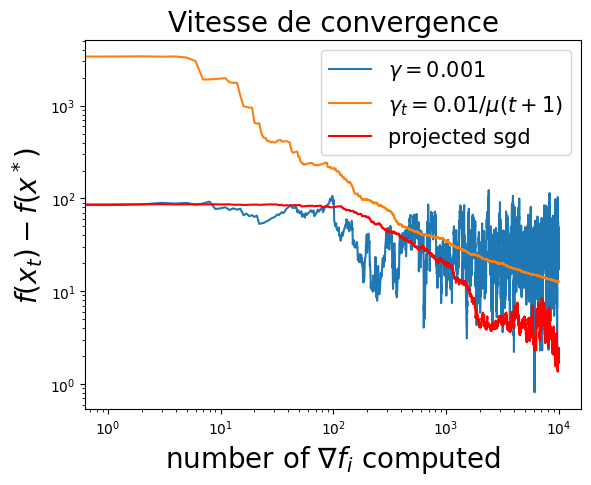

In [48]:
plt.title('Vitesse de convergence', fontsize = 20)
plt.loglog(sgd_objectives - best_objective, label = r'$\gamma = 0.001$')
plt.loglog(sgd_objectives_dec_gamma_mu - best_objective, label = r'$\gamma_t = 0.01 / \mu (t + 1)$')
plt.loglog(psgd_objectives - best_objective,'r', label='projected sgd')
plt.xlabel(r'number of $\nabla f_i$ computed'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)
plt.legend(fontsize = 15)
plt.show()